In [1]:
import torch
from constants import TRAIN_TRANSFORM, batch_size, latent_dim, lr, epochs
from torch.utils.data import random_split, DataLoader

from model import CVAE
from dataset import CelebADataset
from scoring import get_fid_score
import numpy as np
from utils import get_tsne, plot_representation
import pandas as pd
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

In [7]:
# Read the attributes CSV file
attributes_df = pd.read_csv("./data/list_attr_celeba.csv")
# Change -1 values in the dataframe to 0
# attributes_df.replace(to_replace=-1, value=0, inplace=True)

# Number of attributes
n_attributes = attributes_df.shape[1] - 1
print(n_attributes)

40


In [3]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Load and split the CelebA dataset
celeba_data_path = './data/img_align_celeba/img_align_celeba/'

dataset = CelebADataset(celeba_data_path, attributes_df, transform=TRAIN_TRANSFORM)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# Create the VAE model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Number of images: 162079


In [4]:
model = CVAE(latent_dim, n_attributes).to(device)

model.load_state_dict(torch.load('./saved_models/cvae2.pth'))
encoder = model.encoder
encoder = encoder.to(device)

model.eval()
encoder.eval()

Encoder(
  (linear1): Linear(in_features=40, out_features=4096, bias=True)
  (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
)

Epoch [0/1]: 100%|██████████| 127/127 [01:05<00:00,  1.94it/s]


FID score: 151.7354


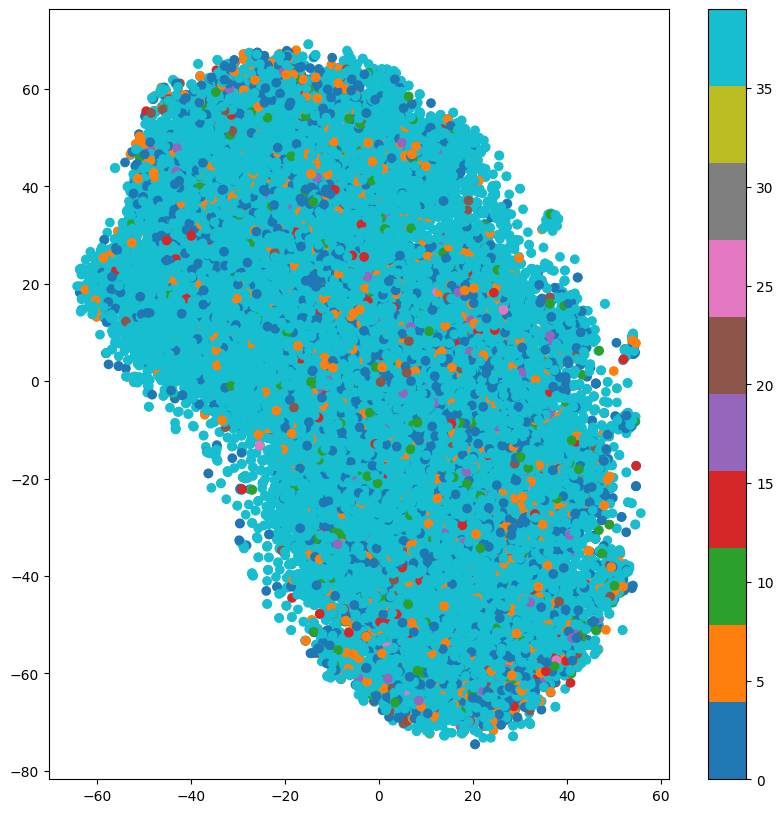

In [6]:
fid_score = FrechetInceptionDistance(n_features=64).to(device)

latent_rep = []
labels = []

with torch.no_grad():
    for imgs, label in tqdm(val_loader, desc=f"Epoch [{0}/{1}]"):
        imgs = imgs.to(device)
        label_one_hot = label.to(device)
        x, _, _ = encoder(imgs, label_one_hot)
        
        # get the last column of the label
        label_to_assign = []

        for l in label:
            if l[-1] == 1:
                label_to_assign.append(len(l) - 1)
            else:
                for i, attr in enumerate(l):
                    if attr == 1:
                        label_to_assign.append(i)
                        break

        latent_rep.append(x.cpu().numpy())
        labels.append(label_to_assign)
        
        z, _, _ = model(imgs, label_one_hot)

        fid_score = get_fid_score(fid_score, imgs, z)

print(f'FID score: {fid_score.compute():.4f}')

labels = np.concatenate(labels, axis=0)
latent_rep = np.concatenate(latent_rep, axis=0)

tsne = get_tsne(latent_rep, no_components=2)

plot_representation(latent_rep=tsne, labels=labels)